<a href="https://colab.research.google.com/github/RayAKaan/RH-MHA/blob/main/Iteration-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numpy as np
from collections import defaultdict

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [3]:
class CopyTaskDataset(torch.utils.data.Dataset):
    """
    Long-range copy / recall task.
    The model must recall a token that appeared early in the sequence
    when queried much later.
    """

    def __init__(
        self,
        seq_len=384,
        vocab_size=50,
        n_samples=10000,
        query_token=0
    ):
        assert seq_len % 16 == 0, "seq_len must be divisible by window size (16)"
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.n_samples = n_samples
        self.query_token = query_token

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Tokens in [1, vocab_size-1]
        x = torch.randint(1, self.vocab_size, (self.seq_len,))

        # Early information position
        info_pos = torch.randint(0, self.seq_len // 4, (1,)).item()

        # Late query position
        query_pos = torch.randint(self.seq_len // 2, self.seq_len, (1,)).item()

        # Ensure no collision
        while info_pos == query_pos:
            info_pos = torch.randint(0, self.seq_len // 4, (1,)).item()

        x[query_pos] = self.query_token
        y = x[info_pos].clone()

        return x, y

In [4]:
class BaselineTransformer(nn.Module):
    """
    Standard Transformer baseline for long-range recall.
    """

    def __init__(
        self,
        vocab_size,
        d_model=128,
        n_layers=4,
        n_heads=4,
        max_seq_len=512
    ):
        super().__init__()

        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            batch_first=True,
            norm_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, N = x.shape
        pos = torch.arange(N, device=x.device).unsqueeze(0).expand(B, N)
        x = self.embed(x) + self.pos_embed(pos)
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.fc(x)

In [5]:
class RH_MHA_v1(nn.Module):
    """
    Recursive Hierarchical Multi-Head Attention (v1)
    """

    def __init__(
        self,
        d_model,
        heads,
        window=16,
        K=2,
        alpha=0.2,
        beta=0.1
    ):
        super().__init__()

        assert d_model % heads == 0
        self.d = d_model
        self.h = heads
        self.dh = d_model // heads
        self.window = window
        self.K = K
        self.alpha = alpha
        self.beta = beta

        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)

        self.out = nn.Linear(d_model, d_model, bias=False)

        self.ln_q = nn.LayerNorm(d_model)
        self.ln_k = nn.LayerNorm(d_model)
        self.ln_v = nn.LayerNorm(d_model)
        self.ln_x = nn.LayerNorm(d_model)

        self.reset_metrics()

    def reset_metrics(self):
        self.metrics = {
            "delta": [],
            "entropy": [],
            "qkv_drift": []
        }

    def _attn(self, Q, K, V):
        B, T, D = Q.shape
        Q = Q.view(B, T, self.h, self.dh).transpose(1, 2)
        K = K.view(B, T, self.h, self.dh).transpose(1, 2)
        V = V.view(B, T, self.h, self.dh).transpose(1, 2)

        scores = (Q @ K.transpose(-2, -1)) / (self.dh ** 0.5)
        A = scores.softmax(dim=-1)
        entropy = -(A * (A + 1e-9).log()).sum(dim=-1).mean().item()
        out = (A @ V).transpose(1, 2).contiguous().view(B, T, D)
        return out, entropy

    def forward(self, x):
        self.reset_metrics()

        B, N, D = x.shape
        assert N % self.window == 0

        M = N // self.window
        xw = x.view(B, M, self.window, D)
        s = xw.mean(dim=2)

        Qw, Kw, Vw = self.Wq(xw), self.Wk(xw), self.Wv(xw)
        Qs, Ks, Vs = self.Wq(s), self.Wk(s), self.Wv(s)

        for _ in range(self.K):
            Q_prev = Qw.detach()

            Vw_hat, H = self._attn(
                Qw.view(B*M, self.window, D),
                Kw.view(B*M, self.window, D),
                Vw.view(B*M, self.window, D)
            )
            Vw_hat = Vw_hat.view(B, M, self.window, D)

            Qw = self.ln_q(Qw + self.beta * self.Wq(Vw_hat))
            Kw = self.ln_k(Kw + self.beta * self.Wk(Vw_hat))
            Vw = self.ln_v(Vw + self.beta * self.Wv(Vw_hat))

            delta = (Qw - Q_prev).norm(dim=-1).mean().item()
            drift = (Qw.norm() + Kw.norm() + Vw.norm()).item()

            self.metrics["delta"].append(delta)
            self.metrics["entropy"].append(H)
            self.metrics["qkv_drift"].append(drift)

            s = Vw.mean(dim=2)
            Vs_hat, _ = self._attn(Qs, Ks, Vs)

            Qs = self.ln_q(Qs + self.beta * self.Wq(Vs_hat))
            Ks = self.ln_k(Ks + self.beta * self.Wk(Vs_hat))
            Vs = self.ln_v(Vs + self.beta * self.Wv(Vs_hat))

            xw = self.ln_x(xw + self.alpha * Vs.unsqueeze(2))

        return self.out(xw.view(B, N, D))

In [6]:
class RHTransformer(nn.Module):
    def __init__(
        self,
        vocab,
        d_model=128,
        heads=4,
        window=16,
        K=2,
        max_seq_len=512
    ):
        super().__init__()

        self.embed = nn.Embedding(vocab, d_model)
        self.pos_embed = nn.Embedding(max_seq_len, d_model)

        self.rh = RH_MHA_v1(
            d_model=d_model,
            heads=heads,
            window=window,
            K=K
        )

        self.fc = nn.Linear(d_model, vocab)

    def forward(self, x):
        B, N = x.shape
        pos = torch.arange(N, device=x.device).unsqueeze(0).expand(B, N)
        x = self.embed(x) + self.pos_embed(pos)
        x = self.rh(x)
        x = x.mean(dim=1)
        return self.fc(x)

In [7]:
def train(model, loader, epochs=5):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
    loss_fn = nn.CrossEntropyLoss()

    history = {"loss": [], "accuracy": []}

    for ep in range(epochs):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0

        for x, y in tqdm(loader, desc=f"Epoch {ep+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()

            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            epoch_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=-1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        history["loss"].append(epoch_loss / total)
        history["accuracy"].append(correct / total)

        print(
            f"[Epoch {ep+1}] "
            f"Loss: {history['loss'][-1]:.4f} | "
            f"Accuracy: {history['accuracy'][-1]:.4f}"
        )

    return history

In [14]:
TRAIN_SEQ_LEN = 768
MAX_SEQ_LEN   = 1024
VOCAB_SIZE    = 50
BATCH_SIZE    = 32
EPOCHS        = 3

train_dataset = CopyTaskDataset(
    seq_len=TRAIN_SEQ_LEN,
    vocab_size=VOCAB_SIZE
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

baseline = BaselineTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=128,
    n_layers=4,
    n_heads=4,
    max_seq_len=MAX_SEQ_LEN
).to(device)

rh_model = RHTransformer(
    vocab=VOCAB_SIZE,
    d_model=128,
    heads=4,
    window=16,
    K=3,
    max_seq_len=MAX_SEQ_LEN
).to(device)

assert MAX_SEQ_LEN >= TRAIN_SEQ_LEN

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [15]:
history_base = train(baseline, train_loader, epochs=EPOCHS)
history_rh   = train(rh_model, train_loader, epochs=EPOCHS)

Epoch 1/3: 100%|██████████| 313/313 [01:22<00:00,  3.79it/s]


[Epoch 1] Loss: 4.0136 | Accuracy: 0.0198


Epoch 2/3: 100%|██████████| 313/313 [01:21<00:00,  3.83it/s]


[Epoch 2] Loss: 3.9403 | Accuracy: 0.0189


Epoch 3/3: 100%|██████████| 313/313 [01:21<00:00,  3.86it/s]


[Epoch 3] Loss: 3.9143 | Accuracy: 0.0195


Epoch 1/3: 100%|██████████| 313/313 [00:07<00:00, 41.17it/s]


[Epoch 1] Loss: 3.9034 | Accuracy: 0.0185


Epoch 2/3: 100%|██████████| 313/313 [00:07<00:00, 39.55it/s]


[Epoch 2] Loss: 3.8987 | Accuracy: 0.0204


Epoch 3/3: 100%|██████████| 313/313 [00:07<00:00, 39.65it/s]

[Epoch 3] Loss: 3.8951 | Accuracy: 0.0245


In [16]:
import pandas as pd
import time

# Helper: Measure throughput (iterations/sec)

def measure_throughput(model, loader, num_batches=50):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= num_batches:
                break
            x = x.to(device)
            _ = model(x)
    elapsed = time.time() - start
    return num_batches / elapsed

# Helper: Aggregate RH-MHA recursion metrics

def aggregate_rh_metrics(rh_model, loader, max_batches=100):
    rh_model.eval()

    delta, entropy, drift = [], [], []

    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= max_batches:
                break
            x = x.to(device)
            _ = rh_model(x)

            delta.extend(rh_model.rh.metrics["delta"])
            entropy.extend(rh_model.rh.metrics["entropy"])
            drift.extend(rh_model.rh.metrics["qkv_drift"])

    return {
        "Δ_rep_mean": np.mean(delta),
        "Δ_rep_std": np.std(delta),
        "attn_entropy_mean": np.mean(entropy),
        "attn_entropy_std": np.std(entropy),
        "qkv_drift_mean": np.mean(drift),
        "qkv_drift_std": np.std(drift),
    }

# Collect metrics

baseline_throughput = measure_throughput(baseline, train_loader)
rh_throughput       = measure_throughput(rh_model, train_loader)

rh_internal_metrics = aggregate_rh_metrics(rh_model, train_loader)

# Comparison table

metrics_table = pd.DataFrame([
    {
        "Model": "Baseline Transformer",
        "Final Loss": history_base["loss"][-1],
        "Final Accuracy": history_base["accuracy"][-1],
        "Throughput (it/s)": baseline_throughput,
        "Δ Representation": "N/A",
        "Attention Entropy": "N/A",
        "QKV Drift": "N/A",
    },
    {
        "Model": "RH-MHA",
        "Final Loss": history_rh["loss"][-1],
        "Final Accuracy": history_rh["accuracy"][-1],
        "Throughput (it/s)": rh_throughput,
        "Δ Representation": f"{rh_internal_metrics['Δ_rep_mean']:.4f} ± {rh_internal_metrics['Δ_rep_std']:.4f}",
        "Attention Entropy": f"{rh_internal_metrics['attn_entropy_mean']:.4f} ± {rh_internal_metrics['attn_entropy_std']:.4f}",
        "QKV Drift": f"{rh_internal_metrics['qkv_drift_mean']:.4f} ± {rh_internal_metrics['qkv_drift_std']:.4f}",
    }
])

display(metrics_table)

metrics_table.to_csv("model_comparison_metrics.csv", index=False)
print("Saved: model_comparison_metrics.csv")

,Model,Final Loss,Final Accuracy,Throughput (it/s),Δ Representation,Attention Entropy,QKV Drift
0,Baseline Transformer,3.914345,0.0195,14.956384,N/A,N/A,N/A
1,RH-MHA,3.895056,0.0245,51.935491,0.8995 ± 0.8666,2.3911 ± 0.0980,5308.8151 ± 0.9327


Saved: model_comparison_metrics.csv


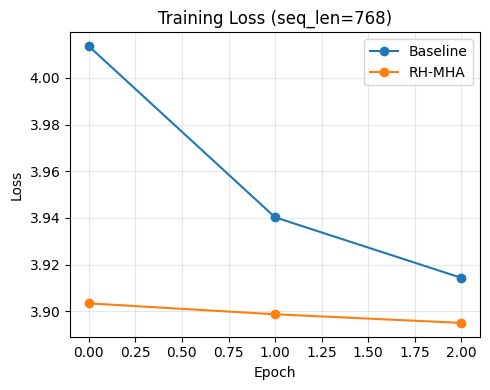

In [17]:
plt.figure(figsize=(5, 4))
plt.plot(history_base["loss"], marker="o", label="Baseline")
plt.plot(history_rh["loss"], marker="o", label="RH-MHA")
plt.title(f"Training Loss (seq_len={TRAIN_SEQ_LEN})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

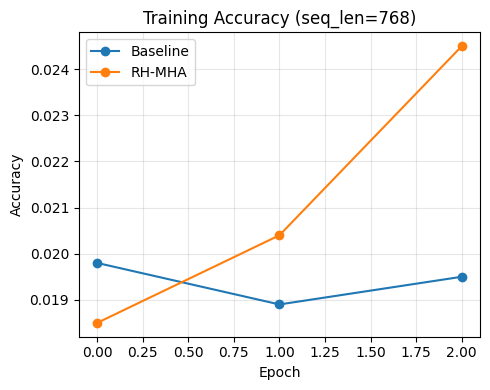

In [18]:
plt.figure(figsize=(5, 4))
plt.plot(history_base["accuracy"], marker="o", label="Baseline")
plt.plot(history_rh["accuracy"], marker="o", label="RH-MHA")
plt.title(f"Training Accuracy (seq_len={TRAIN_SEQ_LEN})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

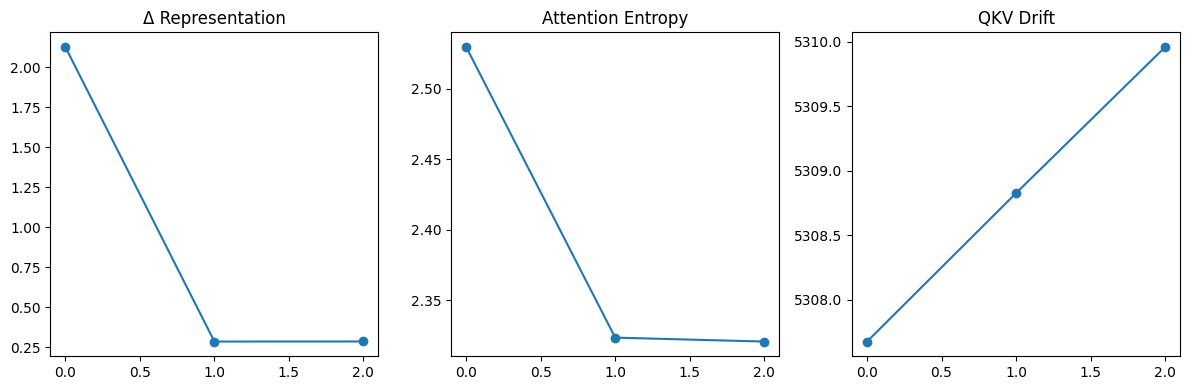

In [19]:
delta_log = defaultdict(list)
entropy_log = defaultdict(list)
drift_log = defaultdict(list)

MAX_BATCHES = 200
rh_model.eval()

with torch.no_grad():
    for i, (x, _) in enumerate(train_loader):
        if i >= MAX_BATCHES:
            break
        x = x.to(device)
        _ = rh_model(x)

        for k in range(len(rh_model.rh.metrics["delta"])):
            delta_log[k].append(rh_model.rh.metrics["delta"][k])
            entropy_log[k].append(rh_model.rh.metrics["entropy"][k])
            drift_log[k].append(rh_model.rh.metrics["qkv_drift"][k])

avg_delta = [np.mean(delta_log[k]) for k in delta_log]
avg_entropy = [np.mean(entropy_log[k]) for k in entropy_log]
avg_drift = [np.mean(drift_log[k]) for k in drift_log]

plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.plot(avg_delta, marker="o"); plt.title("Δ Representation")
plt.subplot(1,3,2); plt.plot(avg_entropy, marker="o"); plt.title("Attention Entropy")
plt.subplot(1,3,3); plt.plot(avg_drift, marker="o"); plt.title("QKV Drift")
plt.tight_layout()
plt.show()